<a href="https://colab.research.google.com/github/mathocosta/TCC/blob/master/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clusterização com o K-Means


## Configuração Inicial
Abaixo estão as configurações feitas para ter acesso aos arquivos no Drive. Será solicitado um código de autorização antes de ter acesso.

In [1]:
import os
from google.colab import drive

# Prepara os arquivos do drive
drive.mount('/content/drive')

# Caminho para os arquivos da análise
baseFolder = '/content/drive/My Drive/TCC/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Carregando modelo do GloVe
Abaixo é carregado o modelo de embeddings a partir do arquivo do GloVe baixado e salvo na pasta do Drive. O método retorna um dicionário onde as chaves são as palavras e os valores são as representações dessas palavras.

In [2]:
import numpy as np

def loadGloVeModel(gloveFile):
    print("Carregando modelo do GloVe...")
    
    with open(gloveFile, encoding="utf8") as f:
        content = f.readlines()
      
    model = {}
    for line in content:
        splitLine = line.split(" ")
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
  
    print("Finalizado.",len(model)," palavras carregadas")
  
    return model

gloveFilename = os.path.join(baseFolder, 'glove_embeddings/glove_s50.txt')
gloveModel = loadGloVeModel(gloveFilename)


Carregando modelo do GloVe...
Finalizado. 929606  palavras carregadas


## Carregando os textos

In [3]:
def textsFromFolder(dataPath):
    print("Carregando textos para análise...")
    texts = []
    for r, d, f in os.walk(dataPath):
        for file in f:
            if '.txt' in file:
                text = open(os.path.join(r, file)).read()
                texts.append(text)

    return texts

samplesFolderPath = os.path.join(baseFolder, '100_textos')
sampleTexts = textsFromFolder(samplesFolderPath)

print("{} textos carregados".format(len(sampleTexts)))


Carregando textos para análise...
100 textos carregados


## Processamento dos textos
Abaixo ocorre o processamento dos textos. Cada etapa está explicada separadamente.


### Criação do vocabulário com o TFIDF

É criado um vocabulário de palavras mais importantes nos textos utilizando a técnica TFIDF, esse passo tem como objetivo remover as *stop words*, que são palavras inúteis para a análise. Isso também faz com que menos palavras sejam convertidas para suas representações vetoriais, otimizando o sistema.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

def createVocabulary(corpus):
    print("Criando vocabulário com o corpus dos textos...")
    vectorizer = TfidfVectorizer(
        max_df = 0.1,
        analyzer = 'word', 
        max_features = 2000
    )
    vectorizer.fit(corpus)

    return vectorizer.get_feature_names()

vocabulary = createVocabulary(sampleTexts)

Criando vocabulário com o corpus dos textos...


### Representação vetorial dos textos

Nessa etapa, o objetivo é obter uma representação vetorial de uma sentença de palavras, no caso, do texto completo. Primeiramente, é preciso tratar as palavras para otimizar a obtenção delas no GloVe, para isso é removido os caracteres especiais e transformadas para *lowercase*, já que a maioria das palavras estão salvas dessa maneira. 

Ao final do processo, é calculada a média das representações vetoriais das palavras. Esse único vetor irá representar o texto.

In [0]:
import re

def vectorizeSentence(sentence, model, vocabulary):
    sentenceVector = []
    wordCounter = 0
    senteceWords = sentence.split(" ")

    for word in senteceWords:
        try:
            # Remove os caracteres especiais, deixa somente alfanuméricos
            word = re.sub('[^A-Za-z0-9]+', '', word)
            # Coloca a palavra para lowercase
            word = word.lower()
            # Somente obtem a representação e adiciona ao conjunto caso esteja
            # presente no vocabulário
            if word in vocabulary:
                if wordCounter == 0:
                    sentenceVector = model[word]
                else:
                    sentenceVector = np.add(sentenceVector, model[word])
            
                wordCounter += 1

        # Erro de quando uma key não está presente no modelo
        except (KeyError):
            # print(word)
            continue

    return np.true_divide(sentenceVector, wordCounter)  


X = []
for text in sampleTexts:
    textVector = vectorizeSentence(text, gloveModel, vocabulary)
    X.append(textVector)
  

## Clusterização

### Execução do K-Means

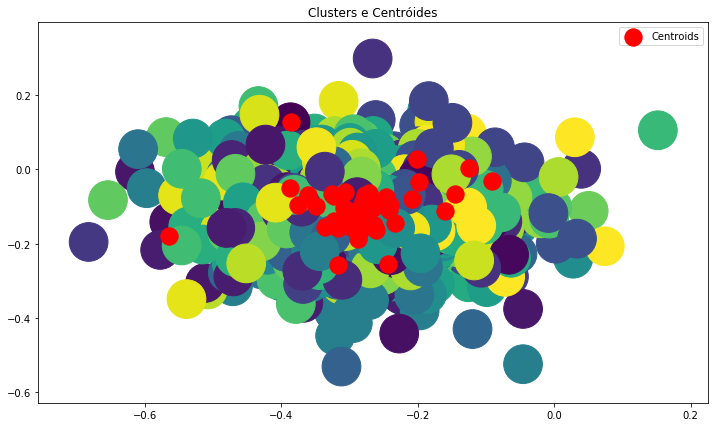

In [0]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 50, init = 'k-means++')
kmeans.fit(X)

XArray = np.asarray(X)
plt.rcParams['figure.figsize'] = (12, 7) 
plt.scatter(XArray[:, 0], XArray[:, 1], s = 1500, c = kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'red', label = 'Centroids')
plt.title('Clusters e Centróides')
plt.legend()
plt.show()


### Elbow Method

In [0]:
import matplotlib.pyplot as plt

wcss = []
elbowRange = range(1, 700, 10)

for i in elbowRange:
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.rcParams['figure.figsize'] = (12, 7) 
plt.plot(elbowRange, wcss)
plt.title('Método Elbow')
plt.xlabel('Número de Clusters')
plt.ylabel('WSS') #within cluster sum of squares
plt.show()
